In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt


import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
import pickle
%matplotlib inline


import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20190408/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1083-2', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1083-2': '/home/brad/krista/B1083/P03S05'}

bird = 'B1083'
block_path = bps[bird]

# Parameters for binning
winsize = 10.0               # binning window size in milliseconds
dtovr = winsize*0.5          # window overlap in milliseconds
comment = 'ForSCM'         # We're plotting betti curves
segment_info = [0,0]       # We want the whole stimulus and just the stimulus

# Parameters for Betti curve computation
thresh = 13.0                            # Activation threshold
nperms = None                            # No permutations of the population - use full pop
ncellsperm = 20                          # Number of cells to subsample for each permuation
dims = [0,1,2,3,4]                        # Compute first five betti numbers
Ntimes = 1000                            # Number of interpolation points
stimlen = 6000                           # Stimulus length in milliseconds
twin = np.linspace(0, stimlen, Ntimes)   # Vector of interpolation time points


In [3]:
# Bin the data from each bird
bdfs = {}
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned
Data Not already binned
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20190408T161236Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T185704Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T220619Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-

In [4]:
reload(tp2)
bc_tavg_store = {}
t_store = {}
tms_store = {}
bc_tavg_shuff_store = {}

for bird in birds:
    bdf = bdfs[bird]
    block_path = bps[bird]
    # compute real and shuffled betti curves - TrialAverage
    print('Computing trial average')
    (bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    (bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr, shuffle=True)
    bc_tavg_store[bird] = bc_tavg
    bc_tavg_shuff_store[bird] = bc_tavg_shuff
    t_store[bird] = t
    tms_store[bird] = tms

Computing trial average
Computing trial average
Computing trial average
Computing trial average
Computing trial average


In [5]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

def plot_scm_distrib(scm_bettis, bettinum, maxbin=200, ax=None, **kwargs):
    
    nmaxtot = 0
    
    bettis = scm_bettis[:, 0, bettinum]
    bettis = bettis[bettis >=0]
    #print(bettis)
    maxbettival = np.amax(bettis)
    maxbin = round(1.5*(maxbettival+1))
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettis, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [6]:
# average over all trials
import tqdm
nsamples = 200
bird_scm_dict = {}
for bird in birds:
    bdf = bdfs[bird]
    stim_dict = {}
    stim_shuffled_dict = {}
    stim_scm_dict = {}
    stim_betticurve_dict = {}
    stim_shuffled_betticurve_dict = {}
    with h5.File(bdf, 'r') as bdff:
        stims = bdff.keys()
        for stim in tqdm.tqdm(stims):
            #print(stim)
            trial=0
            stim_poptens = tp2.extract_population_tensor(bdf, stim)
            ntrials = tp2.num_trials(stim_poptens)
            stim_scm_dat= []
            stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
            scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
            stim_scm_dict[stim] = scm_bettis
    bird_scm_dict[bird] = stim_scm_dict


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [13:08, 788.79s/it]
2it [13:09, 394.63s/it]
3it [13:09, 263.26s/it]
4it [13:10, 197.57s/it]
5it [13:10, 158.16s/it]
6it [13:11, 131.87s/it]
7it [13:11, 113.10s/it]
8it [13:12, 99.01s/it] 
9it [13:12, 88.06s/it]
10it [13:12, 79.30s/it]
11it [13:13, 72.13s/it]
12it [13:13, 66.16s/it]
13it [13:14, 61.11s/it]
14it [13:14, 56.78s/it]
15it [13:15, 53.02s/it]
16it [13:15, 49.74s/it]
17it [13:16, 46.84s/it]
18it [13:16, 44.26s/it]
19it [13:17, 41.96s/it]
20it [13:17, 39.89s/it]
21it [13:18, 38.01s/it]
22it [13:18, 36.30s/it]
23it [13:19, 34.75s/it]
24it [13:19, 33.32s/it]
25it [13:20, 32.01s/it]
26it [13:20, 30.80s/it]
27it [13:21, 29.68s/it]
28it [13:21, 28.64s/it]
29it [13:22, 27.67s/it]
30it [13:22, 26.76s/it]
31it [13:23, 25.91s/it]
32it [13:23, 25.11s/it]
33it [13:24, 24.37s/it]
34it [13:24, 23.67s/it]
35it [13:25, 23.00s/it]
36it [13:25, 22.38s/it]
37it [13:25, 21.78s/it]
38it [13:26, 21.22s/it]
39it [13:26, 20.69s/it]
40it [13:27, 20.19s/it]
41it [13:27, 19.70s/it]
42it [13:28, 19.

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:25, 565.70s/it]
2it [09:25, 282.91s/it]
3it [09:25, 188.64s/it]
4it [09:26, 141.51s/it]
6it [09:26, 94.37s/it] 
7it [09:26, 80.90s/it]
8it [09:26, 70.80s/it]
9it [09:26, 62.95s/it]
10it [09:26, 56.67s/it]
11it [09:26, 51.52s/it]
12it [09:26, 47.24s/it]
13it [09:26, 43.61s/it]
14it [09:27, 40.51s/it]
15it [09:27, 37.81s/it]
16it [09:27, 35.46s/it]
17it [09:27, 33.38s/it]
18it [09:27, 31.53s/it]
19it [09:27, 29.88s/it]
20it [09:27, 28.39s/it]
22it [09:27, 25.82s/it]
24it [09:28, 23.67s/it]
26it [09:28, 21.86s/it]
28it [09:28, 20.30s/it]
30it [09:28, 18.96s/it]
32it [09:28, 17.78s/it]
34it [09:29, 16.74s/it]
35it [09:29, 16.27s/it]
37it [09:29, 15.39s/it]
39it [09:29, 14.61s/it]
40it [09:29, 14.24s/it]
42it [09:29, 13.57s/it]
44it [09:30, 12.96s/it]
45it [09:30, 12.67s/it]
46it [09:30, 12.40s/it]
48it [09:30, 11.89s/it]
49it [09:30, 11.65s/it]
50it [09:30, 11.42s/it]
51it [09:30, 11.19s/it]
52it [09:31, 10.98s/it]
53it [09:31, 10.78s/it]
54it [09:31, 10.58s/it]
55it [09:31, 10.39

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [09:38, 578.78s/it]
2it [09:38, 289.48s/it]
3it [09:39, 193.05s/it]
4it [09:39, 144.84s/it]
5it [09:39, 115.91s/it]
6it [09:39, 96.62s/it] 
7it [09:39, 82.84s/it]
8it [09:40, 72.51s/it]
9it [09:40, 64.47s/it]
10it [09:40, 58.05s/it]
11it [09:40, 52.79s/it]
12it [09:40, 48.40s/it]
13it [09:41, 44.69s/it]
14it [09:41, 41.51s/it]
15it [09:41, 38.76s/it]
16it [09:41, 36.35s/it]
17it [09:41, 34.22s/it]
18it [09:41, 32.33s/it]
19it [09:42, 30.64s/it]
20it [09:42, 29.12s/it]
21it [09:42, 27.74s/it]
22it [09:42, 26.49s/it]
23it [09:42, 25.34s/it]
24it [09:43, 24.30s/it]
25it [09:43, 23.33s/it]
26it [09:43, 22.44s/it]
27it [09:43, 21.62s/it]
28it [09:43, 20.85s/it]
29it [09:44, 20.14s/it]
30it [09:44, 19.48s/it]
31it [09:44, 18.85s/it]
32it [09:44, 18.27s/it]
33it [09:44, 17.72s/it]
34it [09:45, 17.21s/it]
35it [09:45, 16.72s/it]
36it [09:45, 16.26s/it]
37it [09:45, 15.83s/it]
38it [09:45, 15.42s/it]
39it [09:45, 15.02s/it]
40it [09:46, 14.65s/it]
41it [09:46, 14.30s/it]
42it [09:46, 13.97

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:26, 266.70s/it]
2it [04:27, 133.50s/it]
3it [04:27, 89.10s/it] 
4it [04:27, 66.90s/it]
5it [04:27, 53.59s/it]
6it [04:28, 44.71s/it]
7it [04:28, 38.38s/it]
8it [04:28, 33.62s/it]
9it [04:29, 29.93s/it]
10it [04:29, 26.97s/it]
11it [04:29, 24.54s/it]
12it [04:30, 22.53s/it]
13it [04:30, 20.82s/it]
14it [04:31, 19.36s/it]
15it [04:31, 18.09s/it]
16it [04:31, 16.98s/it]
17it [04:32, 16.00s/it]
18it [04:32, 15.13s/it]
19it [04:32, 14.35s/it]
20it [04:33, 13.65s/it]
21it [04:33, 13.02s/it]
22it [04:33, 12.44s/it]
23it [04:34, 11.92s/it]
24it [04:34, 11.43s/it]
25it [04:34, 10.99s/it]
26it [04:35, 10.58s/it]
27it [04:35, 10.20s/it]
28it [04:35,  9.85s/it]
29it [04:36,  9.52s/it]
30it [04:36,  9.21s/it]
31it [04:36,  8.92s/it]
32it [04:37,  8.66s/it]
33it [04:37,  8.40s/it]
34it [04:37,  8.17s/it]
35it [04:38,  7.94s/it]
36it [04:38,  7.73s/it]
37it [04:38,  7.53s/it]
38it [04:39,  7.34s/it]
39it [04:39,  7.16s/it]
40it [04:39,  6.99s/it]
41it [04:40,  6.83s/it]
42it [04:40,  6.67s/i

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [11:59, 719.69s/it]
2it [11:59, 359.93s/it]
3it [12:00, 240.00s/it]
4it [12:00, 180.04s/it]
5it [12:00, 144.06s/it]
6it [12:00, 120.08s/it]
7it [12:00, 102.95s/it]
8it [12:00, 90.10s/it] 
9it [12:00, 80.10s/it]
10it [12:01, 72.11s/it]
11it [12:01, 65.57s/it]
12it [12:01, 60.11s/it]
13it [12:01, 55.50s/it]
14it [12:01, 51.55s/it]
15it [12:01, 48.12s/it]
16it [12:02, 45.13s/it]
17it [12:02, 42.48s/it]
18it [12:02, 40.13s/it]
19it [12:02, 38.03s/it]
20it [12:02, 36.13s/it]
21it [12:02, 34.43s/it]
22it [12:03, 32.87s/it]
23it [12:03, 31.45s/it]
24it [12:03, 30.14s/it]
25it [12:03, 28.94s/it]
26it [12:03, 27.84s/it]
27it [12:03, 26.81s/it]
28it [12:04, 25.86s/it]
29it [12:04, 24.97s/it]
30it [12:04, 24.15s/it]
31it [12:04, 23.37s/it]
32it [12:04, 22.65s/it]
33it [12:04, 21.97s/it]
34it [12:05, 21.33s/it]
35it [12:05, 20.72s/it]
36it [12:05, 20.15s/it]
37it [12:05, 19.61s/it]
38it [12:05, 19.10s/it]
39it [12:05, 18.61s/it]
40it [12:06, 18.15s/it]
41it [12:06, 17.71s/it]
42it [12:06, 17.

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [12:47, 767.55s/it]
2it [12:47, 383.94s/it]
3it [12:48, 256.07s/it]
4it [12:48, 192.14s/it]
5it [12:48, 153.78s/it]
6it [12:49, 128.21s/it]
7it [12:49, 109.94s/it]
8it [12:49, 96.25s/it] 
9it [12:50, 85.59s/it]
10it [12:50, 77.06s/it]
11it [12:51, 70.09s/it]
12it [12:51, 64.28s/it]
13it [12:51, 59.36s/it]
14it [12:52, 55.15s/it]
15it [12:52, 51.50s/it]
16it [12:52, 48.30s/it]
17it [12:53, 45.48s/it]
18it [12:53, 42.97s/it]
19it [12:53, 40.73s/it]
20it [12:54, 38.72s/it]
21it [12:54, 36.89s/it]
22it [12:55, 35.23s/it]
23it [12:55, 33.72s/it]
24it [12:55, 32.33s/it]
25it [12:56, 31.05s/it]
26it [12:56, 29.87s/it]
27it [12:56, 28.78s/it]
28it [12:57, 27.76s/it]
29it [12:57, 26.82s/it]
30it [12:58, 25.93s/it]
31it [12:58, 25.11s/it]
32it [12:58, 24.34s/it]
33it [12:59, 23.61s/it]
34it [12:59, 22.93s/it]
35it [12:59, 22.28s/it]
36it [13:00, 21.67s/it]
37it [13:00, 21.10s/it]
38it [13:01, 20.55s/it]
39it [13:01, 20.04s/it]
40it [13:01, 19.54s/it]
41it [13:02, 19.08s/it]
42it [13:02, 18.

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [05:57, 357.75s/it]
5it [05:57, 71.57s/it] 
9it [05:57, 39.77s/it]
13it [05:58, 27.54s/it]
17it [05:58, 21.07s/it]
21it [05:58, 17.06s/it]
25it [05:58, 14.34s/it]
29it [05:58, 12.36s/it]
33it [05:58, 10.87s/it]
37it [05:58,  9.70s/it]
41it [05:58,  8.75s/it]
45it [05:58,  7.98s/it]
49it [05:59,  7.33s/it]
53it [05:59,  6.78s/it]
57it [05:59,  6.30s/it]
61it [05:59,  5.89s/it]
65it [05:59,  5.53s/it]
69it [05:59,  5.21s/it]
73it [05:59,  4.93s/it]
77it [05:59,  4.67s/it]
81it [05:59,  4.44s/it]
85it [06:00,  4.24s/it]
90it [06:00,  4.00s/it]
94it [06:00,  3.83s/it]
98it [06:00,  3.68s/it]
102it [06:00,  3.53s/it]
106it [06:00,  3.40s/it]
110it [06:00,  3.28s/it]
114it [06:00,  3.16s/it]
118it [06:00,  3.06s/it]
122it [06:01,  2.96s/it]
126it [06:01,  2.87s/it]
130it [06:01,  2.78s/it]
134it [06:01,  2.70s/it]
138it [06:01,  2.62s/it]
142it [06:01,  2.55s/it]
146it [06:01,  2.48s/it]
150it [06:01,  2.41s/it]
154it [06:01,  2.35s/it]
158it [06:01,  2.29s/it]
162it [06:02,  2.24s/it]


Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [06:19, 379.08s/it]
4it [06:19, 94.80s/it] 
7it [06:19, 54.19s/it]
10it [06:19, 37.94s/it]
13it [06:19, 29.20s/it]
16it [06:19, 23.73s/it]
19it [06:19, 19.99s/it]
22it [06:19, 17.27s/it]
25it [06:20, 15.20s/it]
28it [06:20, 13.58s/it]
31it [06:20, 12.27s/it]
34it [06:20, 11.19s/it]
37it [06:20, 10.28s/it]
40it [06:20,  9.52s/it]
43it [06:20,  8.85s/it]
46it [06:20,  8.28s/it]
49it [06:20,  7.78s/it]
52it [06:21,  7.33s/it]
55it [06:21,  6.93s/it]
58it [06:21,  6.57s/it]
61it [06:21,  6.25s/it]
64it [06:21,  5.96s/it]
67it [06:21,  5.70s/it]
70it [06:21,  5.45s/it]
73it [06:21,  5.23s/it]
76it [06:22,  5.03s/it]
79it [06:22,  4.84s/it]
82it [06:22,  4.66s/it]
85it [06:22,  4.50s/it]
88it [06:22,  4.35s/it]
91it [06:22,  4.20s/it]
94it [06:22,  4.07s/it]
97it [06:22,  3.95s/it]
100it [06:23,  3.83s/it]
103it [06:23,  3.72s/it]
106it [06:23,  3.62s/it]
109it [06:23,  3.52s/it]
112it [06:23,  3.42s/it]
115it [06:23,  3.34s/it]
118it [06:23,  3.25s/it]
121it [06:23,  3.17s/it]
124it [0

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [04:40, 280.12s/it]
2it [04:40, 140.20s/it]
3it [04:40, 93.55s/it] 
4it [04:40, 70.24s/it]
5it [04:41, 56.25s/it]
6it [04:41, 46.92s/it]
7it [04:41, 40.26s/it]
8it [04:42, 35.26s/it]
9it [04:42, 31.37s/it]
10it [04:42, 28.26s/it]
11it [04:42, 25.71s/it]
12it [04:43, 23.59s/it]
13it [04:43, 21.80s/it]
14it [04:43, 20.26s/it]
15it [04:43, 18.93s/it]
16it [04:44, 17.76s/it]
17it [04:44, 16.74s/it]
18it [04:44, 15.82s/it]
19it [04:44, 15.00s/it]
20it [04:45, 14.27s/it]
21it [04:45, 13.60s/it]
22it [04:45, 13.00s/it]
23it [04:46, 12.44s/it]
24it [04:46, 11.94s/it]
25it [04:46, 11.47s/it]
26it [04:47, 11.04s/it]
27it [04:47, 10.64s/it]
28it [04:47, 10.27s/it]
29it [04:47,  9.93s/it]
30it [04:48,  9.61s/it]
31it [04:48,  9.31s/it]
32it [04:48,  9.03s/it]
33it [04:49,  8.76s/it]
34it [04:49,  8.51s/it]
35it [04:49,  8.28s/it]
36it [04:50,  8.06s/it]
37it [04:50,  7.85s/it]
38it [04:50,  7.65s/it]
39it [04:50,  7.46s/it]
40it [04:51,  7.28s/it]
41it [04:51,  7.11s/it]
42it [04:51,  6.95s/i

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [05:53, 353.58s/it]
2it [05:58, 179.35s/it]
3it [06:02, 120.95s/it]
4it [06:06, 91.61s/it] 
5it [06:11, 74.35s/it]
6it [06:15, 62.65s/it]
7it [06:20, 54.32s/it]
8it [06:23, 47.98s/it]
9it [06:29, 43.25s/it]
10it [06:33, 39.40s/it]
11it [06:38, 36.22s/it]
12it [06:42, 33.55s/it]
13it [06:47, 31.31s/it]
14it [06:51, 29.40s/it]
15it [06:55, 27.72s/it]
16it [07:01, 26.34s/it]
17it [07:05, 25.01s/it]
18it [07:10, 23.91s/it]
19it [07:14, 22.87s/it]
20it [07:20, 22.02s/it]
21it [07:24, 21.16s/it]
22it [07:28, 20.37s/it]
23it [07:32, 19.68s/it]
24it [07:36, 19.04s/it]
25it [07:40, 18.44s/it]
26it [07:46, 17.94s/it]
27it [07:52, 17.49s/it]
28it [07:56, 17.02s/it]
29it [08:00, 16.56s/it]
30it [08:05, 16.18s/it]
31it [08:09, 15.79s/it]
32it [08:13, 15.43s/it]
33it [08:18, 15.10s/it]
34it [08:22, 14.79s/it]
35it [08:26, 14.47s/it]
36it [08:30, 14.17s/it]
37it [08:34, 13.91s/it]
38it [08:39, 13.68s/it]
39it [08:43, 13.43s/it]
40it [08:49, 13.24s/it]
41it [08:53, 13.01s/it]
42it [08:57, 12.79s/

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [05:21, 321.44s/it]
2it [05:21, 160.83s/it]
3it [05:21, 107.29s/it]
4it [05:22, 80.52s/it] 
5it [05:22, 64.45s/it]
6it [05:22, 53.75s/it]
7it [05:22, 46.10s/it]
8it [05:22, 40.37s/it]
9it [05:23, 35.91s/it]
10it [05:23, 32.34s/it]
11it [05:23, 29.42s/it]
12it [05:23, 26.99s/it]
13it [05:24, 24.93s/it]
14it [05:24, 23.17s/it]
15it [05:24, 21.64s/it]
16it [05:24, 20.30s/it]
17it [05:25, 19.12s/it]
18it [05:25, 18.07s/it]
19it [05:25, 17.13s/it]
20it [05:25, 16.28s/it]
21it [05:25, 15.52s/it]
22it [05:26, 14.82s/it]
23it [05:26, 14.19s/it]
24it [05:26, 13.61s/it]
25it [05:26, 13.07s/it]
26it [05:26, 12.58s/it]
27it [05:27, 12.12s/it]
28it [05:27, 11.69s/it]
29it [05:27, 11.30s/it]
30it [05:27, 10.93s/it]
31it [05:28, 10.58s/it]
32it [05:28, 10.26s/it]
33it [05:28,  9.95s/it]
34it [05:28,  9.67s/it]
35it [05:28,  9.40s/it]
36it [05:29,  9.14s/it]
37it [05:29,  8.90s/it]
38it [05:29,  8.67s/it]
39it [05:29,  8.46s/it]
40it [05:29,  8.25s/it]
41it [05:30,  8.05s/it]
42it [05:30,  7.87s/

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [09:31, 571.62s/it]
3it [09:31, 190.58s/it]
5it [09:31, 114.37s/it]
7it [09:31, 81.71s/it] 
9it [09:32, 63.56s/it]
11it [09:32, 52.02s/it]
13it [09:32, 44.02s/it]
15it [09:32, 38.16s/it]
17it [09:32, 33.68s/it]
19it [09:32, 30.14s/it]
21it [09:32, 27.27s/it]
23it [09:32, 24.91s/it]
25it [09:32, 22.92s/it]
27it [09:33, 21.22s/it]
29it [09:33, 19.76s/it]
31it [09:33, 18.49s/it]
33it [09:33, 17.38s/it]
35it [09:33, 16.39s/it]
37it [09:33, 15.50s/it]
39it [09:33, 14.71s/it]
41it [09:33, 14.00s/it]
43it [09:33, 13.35s/it]
45it [09:34, 12.76s/it]
47it [09:34, 12.22s/it]
49it [09:34, 11.72s/it]
51it [09:34, 11.26s/it]
53it [09:34, 10.84s/it]
55it [09:34, 10.45s/it]
57it [09:34, 10.08s/it]
59it [09:34,  9.74s/it]
61it [09:34,  9.43s/it]
63it [09:35,  9.13s/it]
65it [09:35,  8.85s/it]
67it [09:35,  8.59s/it]
69it [09:35,  8.34s/it]
71it [09:35,  8.11s/it]
73it [09:35,  7.89s/it]
75it [09:35,  7.68s/it]
77it [09:35,  7.48s/it]
79it [09:36,  7.29s/it]
81it [09:36,  7.11s/it]
83it [09:36,  6.

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [03:57, 237.43s/it]
5it [03:57, 47.51s/it] 
9it [03:57, 26.41s/it]
12it [03:57, 19.82s/it]
15it [03:57, 15.86s/it]
18it [03:58, 13.22s/it]
22it [03:58, 10.82s/it]
25it [03:58,  9.53s/it]
28it [03:58,  8.51s/it]
31it [03:58,  7.69s/it]
34it [03:58,  7.02s/it]
38it [03:58,  6.28s/it]
41it [03:58,  5.82s/it]
44it [03:58,  5.43s/it]
47it [03:59,  5.09s/it]
50it [03:59,  4.78s/it]
54it [03:59,  4.43s/it]
58it [03:59,  4.13s/it]
61it [03:59,  3.93s/it]
64it [03:59,  3.74s/it]
67it [03:59,  3.58s/it]
71it [03:59,  3.38s/it]
74it [03:59,  3.24s/it]
77it [04:00,  3.12s/it]
80it [04:00,  3.00s/it]
83it [04:00,  2.89s/it]
86it [04:00,  2.79s/it]
90it [04:00,  2.67s/it]
93it [04:00,  2.59s/it]
96it [04:00,  2.51s/it]
99it [04:00,  2.43s/it]
102it [04:00,  2.36s/it]
105it [04:01,  2.30s/it]
108it [04:01,  2.23s/it]
111it [04:01,  2.17s/it]
114it [04:01,  2.12s/it]
117it [04:01,  2.06s/it]
120it [04:01,  2.01s/it]
123it [04:01,  1.96s/it]
127it [04:01,  1.90s/it]
130it [04:01,  1.86s/it]
134it 

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [03:56, 236.14s/it]
7it [03:56, 33.75s/it] 
13it [03:56, 18.18s/it]
19it [03:56, 12.45s/it]
25it [03:56,  9.46s/it]
31it [03:56,  7.64s/it]
37it [03:56,  6.40s/it]
43it [03:56,  5.51s/it]
49it [03:57,  4.84s/it]
55it [03:57,  4.31s/it]
61it [03:57,  3.89s/it]
67it [03:57,  3.54s/it]
73it [03:57,  3.25s/it]
79it [03:57,  3.01s/it]
85it [03:57,  2.80s/it]
91it [03:57,  2.61s/it]
97it [03:57,  2.45s/it]
103it [03:57,  2.31s/it]
109it [03:58,  2.18s/it]
115it [03:58,  2.07s/it]
121it [03:58,  1.97s/it]
127it [03:58,  1.88s/it]
133it [03:58,  1.79s/it]
139it [03:58,  1.72s/it]
145it [03:58,  1.65s/it]
151it [03:58,  1.58s/it]
157it [03:58,  1.52s/it]
163it [03:59,  1.47s/it]
169it [03:59,  1.42s/it]
175it [03:59,  1.37s/it]
181it [03:59,  1.32s/it]
187it [03:59,  1.28s/it]
193it [03:59,  1.24s/it]
199it [03:59,  1.20s/it]
 75%|███████▌  | 6/8 [50:06<16:42, 501.16s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [04:40, 280.12s/it]
5it [04:40, 56.05s/it] 
9it [04:40, 31.15s/it]
13it [04:40, 21.57s/it]
17it [04:40, 16.50s/it]
21it [04:40, 13.37s/it]
26it [04:40, 10.80s/it]
30it [04:40,  9.36s/it]
34it [04:41,  8.26s/it]
38it [04:41,  7.40s/it]
42it [04:41,  6.70s/it]
46it [04:41,  6.12s/it]
50it [04:41,  5.63s/it]
55it [04:41,  5.12s/it]
59it [04:41,  4.77s/it]
63it [04:41,  4.47s/it]
67it [04:41,  4.21s/it]
71it [04:42,  3.97s/it]
75it [04:42,  3.76s/it]
79it [04:42,  3.57s/it]
83it [04:42,  3.40s/it]
87it [04:42,  3.25s/it]
91it [04:42,  3.10s/it]
95it [04:42,  2.98s/it]
99it [04:42,  2.86s/it]
103it [04:42,  2.75s/it]
107it [04:42,  2.64s/it]
111it [04:43,  2.55s/it]
115it [04:43,  2.46s/it]
119it [04:43,  2.38s/it]
123it [04:43,  2.30s/it]
127it [04:43,  2.23s/it]
131it [04:43,  2.17s/it]
135it [04:43,  2.10s/it]
139it [04:43,  2.04s/it]
143it [04:43,  1.99s/it]
147it [04:44,  1.93s/it]
151it [04:44,  1.88s/it]
156it [04:44,  1.82s/it]
160it [04:44,  1.78s/it]
164it [04:44,  1.73s/it]


Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [06:07, 367.97s/it]
5it [06:08, 73.62s/it] 
9it [06:08, 40.91s/it]
13it [06:08, 28.33s/it]
17it [06:08, 21.67s/it]
21it [06:08, 17.55s/it]
25it [06:08, 14.75s/it]
29it [06:08, 12.72s/it]
33it [06:08, 11.18s/it]
37it [06:09,  9.97s/it]
41it [06:09,  9.00s/it]
45it [06:09,  8.21s/it]
49it [06:09,  7.54s/it]
53it [06:09,  6.97s/it]
57it [06:09,  6.48s/it]
61it [06:09,  6.06s/it]
65it [06:09,  5.69s/it]
69it [06:09,  5.36s/it]
73it [06:10,  5.07s/it]
77it [06:10,  4.81s/it]
81it [06:10,  4.57s/it]
85it [06:10,  4.36s/it]
89it [06:10,  4.16s/it]
93it [06:10,  3.99s/it]
97it [06:10,  3.82s/it]
101it [06:10,  3.67s/it]
105it [06:10,  3.53s/it]
109it [06:11,  3.40s/it]
113it [06:11,  3.28s/it]
117it [06:11,  3.17s/it]
121it [06:11,  3.07s/it]
125it [06:11,  2.97s/it]
129it [06:11,  2.88s/it]
133it [06:11,  2.80s/it]
137it [06:11,  2.71s/it]
141it [06:11,  2.64s/it]
145it [06:12,  2.57s/it]
149it [06:12,  2.50s/it]
153it [06:12,  2.43s/it]
157it [06:12,  2.37s/it]
161it [06:12,  2.31s/it]


Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [01:30, 90.42s/it]
5it [01:30, 18.11s/it]
9it [01:30, 10.07s/it]
13it [01:30,  6.98s/it]
18it [01:30,  5.05s/it]
23it [01:30,  3.95s/it]
28it [01:31,  3.25s/it]
33it [01:31,  2.76s/it]
37it [01:31,  2.47s/it]
42it [01:31,  2.18s/it]
46it [01:31,  1.99s/it]
50it [01:31,  1.83s/it]
55it [01:31,  1.67s/it]
60it [01:31,  1.53s/it]
65it [01:32,  1.42s/it]
70it [01:32,  1.32s/it]
75it [01:32,  1.23s/it]
80it [01:32,  1.15s/it]
84it [01:32,  1.10s/it]
89it [01:32,  1.04s/it]
94it [01:32,  1.01it/s]
98it [01:32,  1.06it/s]
103it [01:32,  1.11it/s]
108it [01:33,  1.16it/s]
113it [01:33,  1.21it/s]
118it [01:33,  1.26it/s]
123it [01:33,  1.32it/s]
128it [01:33,  1.37it/s]
133it [01:33,  1.42it/s]
137it [01:33,  1.46it/s]
141it [01:33,  1.50it/s]
146it [01:34,  1.55it/s]
150it [01:34,  1.59it/s]
154it [01:34,  1.63it/s]
158it [01:34,  1.67it/s]
161it [01:34,  1.70it/s]
164it [01:35,  1.73it/s]
168it [01:35,  1.77it/s]
172it [01:35,  1.81it/s]
175it [01:35,  1.83it/s]
179it [01:35,  1.87it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:54, 54.14s/it]
9it [00:54,  6.03s/it]
16it [00:54,  3.40s/it]
23it [00:54,  2.37s/it]
30it [00:54,  1.82s/it]
37it [00:54,  1.48s/it]
45it [00:54,  1.22s/it]
53it [00:54,  1.04s/it]
61it [00:54,  1.11it/s]
69it [00:55,  1.25it/s]
77it [00:55,  1.39it/s]
85it [00:55,  1.54it/s]
93it [00:55,  1.68it/s]
101it [00:55,  1.82it/s]
109it [00:55,  1.96it/s]
117it [00:55,  2.10it/s]
125it [00:55,  2.24it/s]
133it [00:56,  2.37it/s]
141it [00:56,  2.51it/s]
149it [00:56,  2.65it/s]
157it [00:56,  2.79it/s]
165it [00:56,  2.92it/s]
173it [00:56,  3.06it/s]
181it [00:56,  3.19it/s]
189it [00:56,  3.33it/s]
197it [00:56,  3.46it/s]
 12%|█▎        | 2/16 [02:33<17:52, 76.63s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [01:02, 62.07s/it]
9it [01:02,  6.91s/it]
15it [01:02,  4.16s/it]
18it [01:02,  3.47s/it]
22it [01:02,  2.85s/it]
30it [01:02,  2.09s/it]
37it [01:02,  1.70s/it]
44it [01:02,  1.43s/it]
51it [01:03,  1.24s/it]
58it [01:03,  1.09s/it]
65it [01:03,  1.03it/s]
72it [01:03,  1.14it/s]
79it [01:03,  1.24it/s]
87it [01:03,  1.37it/s]
95it [01:03,  1.49it/s]
103it [01:03,  1.61it/s]
110it [01:03,  1.72it/s]
118it [01:04,  1.84it/s]
125it [01:04,  1.95it/s]
132it [01:04,  2.05it/s]
140it [01:04,  2.18it/s]
148it [01:04,  2.30it/s]
156it [01:04,  2.42it/s]
164it [01:04,  2.53it/s]
172it [01:04,  2.65it/s]
180it [01:04,  2.77it/s]
188it [01:05,  2.89it/s]
196it [01:05,  3.01it/s]
 19%|█▉        | 3/16 [03:38<15:46, 72.83s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [00:21, 21.96s/it]
10it [00:22,  2.21s/it]
19it [00:22,  1.17s/it]
28it [00:22,  1.26it/s]
36it [00:22,  1.61it/s]
45it [00:22,  2.00it/s]
52it [00:22,  2.30it/s]
61it [00:22,  2.69it/s]
69it [00:22,  3.02it/s]
77it [00:22,  3.36it/s]
85it [00:23,  3.69it/s]
94it [00:23,  4.07it/s]
103it [00:23,  4.44it/s]
112it [00:23,  4.80it/s]
121it [00:23,  5.16it/s]
130it [00:23,  5.52it/s]
139it [00:23,  5.88it/s]
148it [00:23,  6.23it/s]
157it [00:23,  6.58it/s]
166it [00:23,  6.92it/s]
175it [00:24,  7.26it/s]
184it [00:24,  7.60it/s]
193it [00:24,  7.94it/s]
 25%|██▌       | 4/16 [04:02<12:08, 60.72s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:06, 66.70s/it]
4it [01:06, 16.70s/it]
7it [01:06,  9.56s/it]
10it [01:07,  6.71s/it]
13it [01:07,  5.17s/it]
16it [01:07,  4.21s/it]
19it [01:07,  3.55s/it]
22it [01:07,  3.07s/it]
25it [01:07,  2.71s/it]
28it [01:07,  2.42s/it]
31it [01:07,  2.19s/it]
34it [01:08,  2.00s/it]
37it [01:08,  1.84s/it]
40it [01:08,  1.71s/it]
43it [01:08,  1.59s/it]
46it [01:08,  1.49s/it]
49it [01:08,  1.40s/it]
52it [01:08,  1.32s/it]
55it [01:08,  1.25s/it]
58it [01:08,  1.19s/it]
61it [01:09,  1.13s/it]
64it [01:09,  1.08s/it]
67it [01:09,  1.03s/it]
70it [01:09,  1.01it/s]
73it [01:09,  1.05it/s]
76it [01:09,  1.09it/s]
79it [01:09,  1.13it/s]
82it [01:09,  1.17it/s]
85it [01:09,  1.21it/s]
88it [01:10,  1.26it/s]
91it [01:10,  1.30it/s]
94it [01:10,  1.34it/s]
97it [01:10,  1.38it/s]
100it [01:10,  1.42it/s]
103it [01:10,  1.46it/s]
106it [01:10,  1.50it/s]
109it [01:10,  1.54it/s]
112it [01:11,  1.58it/s]
115it [01:11,  1.62it/s]
118it [01:11,  1.66it/s]
121it [01:11,  1.70it/s]
124it [01:

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [00:50, 50.08s/it]
8it [00:50,  6.27s/it]
15it [00:50,  3.35s/it]
22it [00:50,  2.29s/it]
29it [00:50,  1.74s/it]
36it [00:50,  1.41s/it]
43it [00:50,  1.18s/it]
50it [00:50,  1.02s/it]
57it [00:50,  1.12it/s]
64it [00:51,  1.25it/s]
71it [00:51,  1.39it/s]
78it [00:51,  1.52it/s]
85it [00:51,  1.65it/s]
92it [00:51,  1.79it/s]
99it [00:51,  1.92it/s]
106it [00:51,  2.05it/s]
113it [00:51,  2.18it/s]
120it [00:51,  2.31it/s]
127it [00:52,  2.44it/s]
134it [00:52,  2.57it/s]
141it [00:52,  2.70it/s]
148it [00:52,  2.83it/s]
155it [00:52,  2.95it/s]
162it [00:52,  3.08it/s]
169it [00:52,  3.21it/s]
176it [00:52,  3.33it/s]
183it [00:52,  3.46it/s]
190it [00:52,  3.59it/s]
197it [00:53,  3.71it/s]
 38%|███▊      | 6/16 [06:10<10:17, 61.76s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:30, 30.84s/it]
9it [00:30,  3.44s/it]
17it [00:31,  1.83s/it]
25it [00:31,  1.25s/it]
33it [00:31,  1.06it/s]
41it [00:31,  1.31it/s]
50it [00:31,  1.59it/s]
58it [00:31,  1.84it/s]
66it [00:31,  2.08it/s]
74it [00:31,  2.33it/s]
82it [00:31,  2.57it/s]
90it [00:31,  2.81it/s]
98it [00:32,  3.05it/s]
107it [00:32,  3.32it/s]
115it [00:32,  3.56it/s]
123it [00:32,  3.80it/s]
131it [00:32,  4.03it/s]
140it [00:32,  4.29it/s]
148it [00:32,  4.52it/s]
156it [00:32,  4.75it/s]
164it [00:32,  4.98it/s]
172it [00:33,  5.20it/s]
180it [00:33,  5.43it/s]
188it [00:33,  5.65it/s]
196it [00:33,  5.87it/s]
 44%|████▍     | 7/16 [06:44<08:39, 57.72s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [00:36, 36.06s/it]
9it [00:36,  4.02s/it]
16it [00:36,  2.27s/it]
25it [00:36,  1.45s/it]
33it [00:36,  1.11s/it]
42it [00:36,  1.15it/s]
50it [00:36,  1.36it/s]
59it [00:36,  1.60it/s]
67it [00:36,  1.82it/s]
75it [00:37,  2.03it/s]
84it [00:37,  2.26it/s]
92it [00:37,  2.47it/s]
100it [00:37,  2.68it/s]
108it [00:37,  2.88it/s]
116it [00:37,  3.09it/s]
124it [00:37,  3.29it/s]
132it [00:37,  3.50it/s]
141it [00:37,  3.72it/s]
149it [00:37,  3.92it/s]
158it [00:38,  4.15it/s]
166it [00:38,  4.35it/s]
174it [00:38,  4.54it/s]
182it [00:38,  4.74it/s]
190it [00:38,  4.93it/s]
198it [00:38,  5.13it/s]
 50%|█████     | 8/16 [07:22<07:22, 55.34s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:02, 62.39s/it]
7it [01:02,  8.93s/it]
13it [01:02,  4.81s/it]
20it [01:02,  3.14s/it]
26it [01:02,  2.42s/it]
32it [01:02,  1.97s/it]
38it [01:03,  1.66s/it]
44it [01:03,  1.43s/it]
51it [01:03,  1.24s/it]
57it [01:03,  1.11s/it]
63it [01:03,  1.01s/it]
69it [01:03,  1.09it/s]
75it [01:03,  1.18it/s]
82it [01:03,  1.29it/s]
88it [01:03,  1.38it/s]
94it [01:04,  1.47it/s]
100it [01:04,  1.56it/s]
106it [01:04,  1.65it/s]
112it [01:04,  1.74it/s]
118it [01:04,  1.83it/s]
124it [01:04,  1.92it/s]
130it [01:04,  2.01it/s]
137it [01:04,  2.12it/s]
143it [01:04,  2.20it/s]
150it [01:04,  2.31it/s]
156it [01:05,  2.40it/s]
162it [01:05,  2.49it/s]
168it [01:05,  2.57it/s]
174it [01:05,  2.66it/s]
181it [01:05,  2.76it/s]
187it [01:05,  2.85it/s]
193it [01:05,  2.94it/s]
199it [01:05,  3.02it/s]
 56%|█████▋    | 9/16 [08:28<06:35, 56.51s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:19, 79.66s/it]
8it [01:19,  9.97s/it]
16it [01:19,  4.99s/it]
24it [01:19,  3.33s/it]
32it [01:20,  2.50s/it]
40it [01:20,  2.01s/it]
47it [01:20,  1.71s/it]
54it [01:20,  1.49s/it]
61it [01:20,  1.32s/it]
69it [01:20,  1.17s/it]
76it [01:20,  1.06s/it]
84it [01:20,  1.04it/s]
91it [01:20,  1.12it/s]
98it [01:21,  1.21it/s]
106it [01:21,  1.31it/s]
113it [01:21,  1.39it/s]
120it [01:21,  1.47it/s]
127it [01:21,  1.56it/s]
134it [01:21,  1.64it/s]
141it [01:21,  1.73it/s]
148it [01:21,  1.81it/s]
155it [01:21,  1.89it/s]
162it [01:22,  1.97it/s]
169it [01:22,  2.06it/s]
176it [01:22,  2.14it/s]
183it [01:22,  2.22it/s]
190it [01:22,  2.30it/s]
197it [01:22,  2.39it/s]
 62%|██████▎   | 10/16 [09:51<05:54, 59.12s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:19, 79.43s/it]
6it [01:19, 13.26s/it]
10it [01:19,  7.97s/it]
14it [01:19,  5.70s/it]
19it [01:19,  4.20s/it]
24it [01:19,  3.33s/it]
28it [01:20,  2.86s/it]
32it [01:20,  2.51s/it]
37it [01:20,  2.17s/it]
42it [01:20,  1.92s/it]
47it [01:20,  1.71s/it]
52it [01:20,  1.55s/it]
57it [01:20,  1.42s/it]
62it [01:20,  1.31s/it]
67it [01:21,  1.21s/it]
72it [01:21,  1.13s/it]
77it [01:21,  1.06s/it]
82it [01:21,  1.01it/s]
87it [01:21,  1.07it/s]
92it [01:21,  1.13it/s]
97it [01:21,  1.19it/s]
102it [01:21,  1.25it/s]
107it [01:21,  1.30it/s]
112it [01:22,  1.36it/s]
117it [01:22,  1.42it/s]
122it [01:22,  1.48it/s]
127it [01:22,  1.54it/s]
132it [01:22,  1.60it/s]
137it [01:22,  1.66it/s]
142it [01:22,  1.71it/s]
147it [01:22,  1.77it/s]
152it [01:23,  1.83it/s]
157it [01:23,  1.89it/s]
162it [01:23,  1.94it/s]
167it [01:23,  2.00it/s]
172it [01:23,  2.06it/s]
177it [01:23,  2.12it/s]
182it [01:23,  2.17it/s]
187it [01:23,  2.23it/s]
192it [01:24,  2.29it/s]
197it [01:24,  2.34it/

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [00:42, 42.17s/it]
9it [00:42,  4.70s/it]
17it [00:42,  2.49s/it]
25it [00:42,  1.70s/it]
33it [00:42,  1.29s/it]
41it [00:42,  1.04s/it]
49it [00:42,  1.14it/s]
58it [00:42,  1.35it/s]
66it [00:43,  1.53it/s]
74it [00:43,  1.72it/s]
83it [00:43,  1.92it/s]
92it [00:43,  2.12it/s]
101it [00:43,  2.32it/s]
109it [00:43,  2.50it/s]
118it [00:43,  2.70it/s]
126it [00:43,  2.88it/s]
134it [00:43,  3.05it/s]
142it [00:43,  3.23it/s]
150it [00:44,  3.40it/s]
159it [00:44,  3.60it/s]
167it [00:44,  3.77it/s]
176it [00:44,  3.96it/s]
185it [00:44,  4.16it/s]
194it [00:44,  4.35it/s]
 75%|███████▌  | 12/16 [12:00<04:00, 60.01s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [00:43, 43.56s/it]
10it [00:43,  4.37s/it]
18it [00:43,  2.43s/it]
26it [00:43,  1.69s/it]
35it [00:43,  1.26s/it]
43it [00:44,  1.03s/it]
51it [00:44,  1.15it/s]
59it [00:44,  1.33it/s]
67it [00:44,  1.51it/s]
75it [00:44,  1.68it/s]
83it [00:44,  1.86it/s]
91it [00:44,  2.03it/s]
99it [00:44,  2.21it/s]
107it [00:44,  2.38it/s]
115it [00:45,  2.55it/s]
124it [00:45,  2.74it/s]
132it [00:45,  2.92it/s]
140it [00:45,  3.08it/s]
148it [00:45,  3.25it/s]
156it [00:45,  3.42it/s]
165it [00:45,  3.61it/s]
173it [00:45,  3.78it/s]
182it [00:45,  3.96it/s]
190it [00:46,  4.13it/s]
198it [00:46,  4.29it/s]
 81%|████████▏ | 13/16 [12:46<02:56, 58.95s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [00:45, 45.94s/it]
9it [00:46,  5.12s/it]
16it [00:46,  2.88s/it]
24it [00:46,  1.93s/it]
32it [00:46,  1.45s/it]
40it [00:46,  1.16s/it]
48it [00:46,  1.03it/s]
56it [00:46,  1.20it/s]
64it [00:46,  1.37it/s]
72it [00:46,  1.54it/s]
80it [00:46,  1.70it/s]
88it [00:47,  1.87it/s]
96it [00:47,  2.03it/s]
104it [00:47,  2.20it/s]
112it [00:47,  2.36it/s]
120it [00:47,  2.52it/s]
128it [00:47,  2.69it/s]
136it [00:47,  2.85it/s]
144it [00:47,  3.01it/s]
152it [00:47,  3.17it/s]
160it [00:48,  3.33it/s]
168it [00:48,  3.48it/s]
176it [00:48,  3.64it/s]
184it [00:48,  3.80it/s]
192it [00:48,  3.96it/s]
200it [00:48,  4.11it/s]
 88%|████████▊ | 14/16 [13:34<01:56, 58.21s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [01:14, 74.41s/it]
6it [01:14, 12.42s/it]
10it [01:14,  7.46s/it]
15it [01:14,  4.98s/it]
20it [01:14,  3.74s/it]
25it [01:14,  3.00s/it]
30it [01:15,  2.50s/it]
35it [01:15,  2.15s/it]
40it [01:15,  1.88s/it]
45it [01:15,  1.68s/it]
50it [01:15,  1.51s/it]
55it [01:15,  1.38s/it]
60it [01:15,  1.26s/it]
65it [01:15,  1.17s/it]
70it [01:15,  1.09s/it]
75it [01:16,  1.01s/it]
80it [01:16,  1.05it/s]
85it [01:16,  1.11it/s]
90it [01:16,  1.18it/s]
95it [01:16,  1.24it/s]
100it [01:16,  1.30it/s]
105it [01:16,  1.37it/s]
110it [01:16,  1.43it/s]
115it [01:17,  1.49it/s]
120it [01:17,  1.55it/s]
125it [01:17,  1.62it/s]
130it [01:17,  1.68it/s]
135it [01:17,  1.74it/s]
140it [01:17,  1.80it/s]
145it [01:17,  1.87it/s]
150it [01:17,  1.93it/s]
155it [01:17,  1.99it/s]
160it [01:18,  2.05it/s]
165it [01:18,  2.11it/s]
170it [01:18,  2.17it/s]
175it [01:18,  2.23it/s]
180it [01:18,  2.29it/s]
185it [01:18,  2.35it/s]
190it [01:18,  2.41it/s]
195it [01:18,  2.47it/s]
200it [01:19,  2.53it

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [00:35, 35.05s/it]
10it [00:35,  3.52s/it]
18it [00:35,  1.96s/it]
25it [00:35,  1.41s/it]
33it [00:35,  1.07s/it]
41it [00:35,  1.15it/s]
49it [00:35,  1.37it/s]
58it [00:35,  1.62it/s]
66it [00:35,  1.84it/s]
74it [00:36,  2.06it/s]
82it [00:36,  2.27it/s]
90it [00:36,  2.49it/s]
98it [00:36,  2.70it/s]
106it [00:36,  2.91it/s]
114it [00:36,  3.12it/s]
122it [00:36,  3.33it/s]
131it [00:36,  3.57it/s]
139it [00:36,  3.77it/s]
147it [00:36,  3.98it/s]
155it [00:37,  4.18it/s]
163it [00:37,  4.39it/s]
171it [00:37,  4.59it/s]
179it [00:37,  4.79it/s]
187it [00:37,  4.99it/s]
195it [00:37,  5.19it/s]
  0%|          | 0/16 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [00:57, 57.23s/it]
9it [00:57,  6.37s/it]
17it [00:57,  3.38s/it]
25it [00:57,  2.30s/it]
33it [00:57,  1.75s/it]
41it [00:57,  1.41s/it]
49it [00:57,  1.18s/it]
57it [00:57,  1.02s/it]
66it [00:58,  1.14it/s]
74it [00:58,  1.27it/s]
82it [00:58,  1.41it/s]
90it [00:58,  1.54it/s]
99it [00:58,  1.69it/s]
108it [00:58,  1.84it/s]
117it [00:58,  1.99it/s]
126it [00:58,  2.14it/s]
135it [00:58,  2.29it/s]
144it [00:59,  2.44it/s]
152it [00:59,  2.57it/s]
160it [00:59,  2.70it/s]
169it [00:59,  2.85it/s]
177it [00:59,  2.98it/s]
186it [00:59,  3.12it/s]
195it [00:59,  3.27it/s]
  6%|▋         | 1/16 [00:59<14:56, 59.78s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:52, 52.82s/it]
8it [00:52,  6.62s/it]
15it [00:53,  3.54s/it]
23it [00:53,  2.31s/it]
30it [00:53,  1.78s/it]
37it [00:53,  1.44s/it]
44it [00:53,  1.22s/it]
51it [00:53,  1.05s/it]
58it [00:53,  1.08it/s]
65it [00:53,  1.21it/s]
72it [00:53,  1.34it/s]
79it [00:53,  1.46it/s]
86it [00:54,  1.59it/s]
93it [00:54,  1.72it/s]
100it [00:54,  1.84it/s]
107it [00:54,  1.97it/s]
115it [00:54,  2.11it/s]
122it [00:54,  2.23it/s]
129it [00:54,  2.36it/s]
136it [00:54,  2.48it/s]
144it [00:54,  2.62it/s]
152it [00:55,  2.76it/s]
159it [00:55,  2.88it/s]
166it [00:55,  3.00it/s]
173it [00:55,  3.12it/s]
180it [00:55,  3.25it/s]
188it [00:55,  3.38it/s]
196it [00:55,  3.52it/s]
 12%|█▎        | 2/16 [01:55<13:28, 57.78s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [01:05, 65.19s/it]
6it [01:05, 10.88s/it]
12it [01:05,  5.45s/it]
19it [01:05,  3.45s/it]
26it [01:05,  2.52s/it]
33it [01:05,  1.99s/it]
40it [01:05,  1.65s/it]
46it [01:05,  1.43s/it]
53it [01:06,  1.25s/it]
59it [01:06,  1.12s/it]
65it [01:06,  1.02s/it]
72it [01:06,  1.08it/s]
79it [01:06,  1.19it/s]
85it [01:06,  1.28it/s]
92it [01:06,  1.38it/s]
99it [01:06,  1.48it/s]
106it [01:06,  1.58it/s]
113it [01:07,  1.68it/s]
120it [01:07,  1.79it/s]
127it [01:07,  1.89it/s]
134it [01:07,  1.99it/s]
141it [01:07,  2.09it/s]
148it [01:07,  2.19it/s]
155it [01:07,  2.29it/s]
162it [01:07,  2.39it/s]
169it [01:07,  2.49it/s]
176it [01:08,  2.59it/s]
183it [01:08,  2.68it/s]
190it [01:08,  2.78it/s]
197it [01:08,  2.88it/s]
 19%|█▉        | 3/16 [03:04<13:17, 61.35s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [01:21, 81.84s/it]
7it [01:21, 11.71s/it]
13it [01:22,  6.31s/it]
19it [01:22,  4.32s/it]
25it [01:22,  3.29s/it]
31it [01:22,  2.66s/it]
37it [01:22,  2.23s/it]
43it [01:22,  1.92s/it]
49it [01:22,  1.69s/it]
55it [01:22,  1.51s/it]
61it [01:22,  1.36s/it]
67it [01:23,  1.24s/it]
73it [01:23,  1.14s/it]
79it [01:23,  1.05s/it]
85it [01:23,  1.02it/s]
91it [01:23,  1.09it/s]
97it [01:23,  1.16it/s]
103it [01:23,  1.23it/s]
108it [01:23,  1.29it/s]
114it [01:24,  1.36it/s]
120it [01:24,  1.43it/s]
125it [01:24,  1.48it/s]
130it [01:24,  1.54it/s]
135it [01:24,  1.60it/s]
141it [01:24,  1.67it/s]
147it [01:24,  1.74it/s]
153it [01:24,  1.80it/s]
159it [01:24,  1.87it/s]
165it [01:25,  1.94it/s]
171it [01:25,  2.01it/s]
177it [01:25,  2.08it/s]
183it [01:25,  2.14it/s]
189it [01:25,  2.21it/s]
195it [01:25,  2.28it/s]
 25%|██▌       | 4/16 [04:29<13:29, 67.45s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:35, 95.16s/it]
9it [01:35, 10.59s/it]
17it [01:35,  5.61s/it]
25it [01:35,  3.82s/it]
32it [01:35,  2.99s/it]
40it [01:35,  2.39s/it]
47it [01:35,  2.04s/it]
55it [01:35,  1.74s/it]
62it [01:36,  1.55s/it]
70it [01:36,  1.37s/it]
78it [01:36,  1.23s/it]
86it [01:36,  1.12s/it]
94it [01:36,  1.03s/it]
102it [01:36,  1.06it/s]
110it [01:36,  1.14it/s]
118it [01:36,  1.22it/s]
126it [01:36,  1.30it/s]
134it [01:37,  1.38it/s]
142it [01:37,  1.46it/s]
150it [01:37,  1.54it/s]
158it [01:37,  1.62it/s]
166it [01:37,  1.70it/s]
174it [01:37,  1.78it/s]
182it [01:37,  1.86it/s]
190it [01:37,  1.94it/s]
198it [01:38,  2.02it/s]
 31%|███▏      | 5/16 [06:07<13:29, 73.57s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [02:04, 124.92s/it]
7it [02:05, 17.86s/it] 
12it [02:05, 10.43s/it]
18it [02:05,  6.96s/it]
24it [02:05,  5.22s/it]
30it [02:05,  4.18s/it]
36it [02:05,  3.49s/it]
42it [02:05,  2.99s/it]
47it [02:05,  2.68s/it]
53it [02:05,  2.38s/it]
59it [02:06,  2.14s/it]
65it [02:06,  1.94s/it]
71it [02:06,  1.78s/it]
77it [02:06,  1.64s/it]
83it [02:06,  1.52s/it]
89it [02:06,  1.42s/it]
95it [02:06,  1.33s/it]
101it [02:06,  1.26s/it]
107it [02:06,  1.19s/it]
113it [02:07,  1.12s/it]
119it [02:07,  1.07s/it]
125it [02:07,  1.02s/it]
131it [02:07,  1.03it/s]
137it [02:07,  1.07it/s]
143it [02:07,  1.12it/s]
149it [02:07,  1.17it/s]
155it [02:07,  1.21it/s]
161it [02:07,  1.26it/s]
167it [02:08,  1.30it/s]
173it [02:08,  1.35it/s]
179it [02:08,  1.40it/s]
185it [02:08,  1.44it/s]
191it [02:08,  1.49it/s]
197it [02:08,  1.53it/s]
 38%|███▊      | 6/16 [08:16<13:47, 82.76s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:41, 41.68s/it]
5it [00:41,  8.36s/it]
9it [00:41,  4.65s/it]
13it [00:42,  3.23s/it]
17it [00:42,  2.48s/it]
21it [00:42,  2.01s/it]
25it [00:42,  1.69s/it]
29it [00:42,  1.46s/it]
33it [00:42,  1.29s/it]
37it [00:42,  1.15s/it]
41it [00:42,  1.04s/it]
45it [00:42,  1.05it/s]
49it [00:42,  1.14it/s]
54it [00:43,  1.25it/s]
59it [00:43,  1.37it/s]
63it [00:43,  1.45it/s]
67it [00:43,  1.54it/s]
71it [00:43,  1.63it/s]
75it [00:43,  1.72it/s]
79it [00:43,  1.81it/s]
83it [00:43,  1.89it/s]
87it [00:43,  1.98it/s]
91it [00:44,  2.06it/s]
95it [00:44,  2.15it/s]
99it [00:44,  2.23it/s]
103it [00:44,  2.32it/s]
107it [00:44,  2.40it/s]
111it [00:44,  2.49it/s]
115it [00:44,  2.57it/s]
119it [00:44,  2.65it/s]
123it [00:44,  2.74it/s]
127it [00:45,  2.82it/s]
131it [00:45,  2.90it/s]
135it [00:45,  2.98it/s]
139it [00:45,  3.06it/s]
144it [00:45,  3.16it/s]
148it [00:45,  3.24it/s]
152it [00:45,  3.33it/s]
156it [00:45,  3.40it/s]
160it [00:45,  3.48it/s]
164it [00:46,  3.56it/s]
16

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [01:43, 103.81s/it]
4it [01:43, 25.98s/it] 
7it [01:44, 14.86s/it]
10it [01:44, 10.42s/it]
13it [01:44,  8.02s/it]
16it [01:44,  6.53s/it]
19it [01:44,  5.50s/it]
22it [01:44,  4.76s/it]
25it [01:44,  4.19s/it]
28it [01:44,  3.75s/it]
31it [01:45,  3.39s/it]
34it [01:45,  3.09s/it]
37it [01:45,  2.85s/it]
40it [01:45,  2.64s/it]
43it [01:45,  2.45s/it]
46it [01:45,  2.30s/it]
49it [01:45,  2.16s/it]
52it [01:45,  2.04s/it]
55it [01:46,  1.93s/it]
58it [01:46,  1.83s/it]
61it [01:46,  1.74s/it]
64it [01:46,  1.66s/it]
67it [01:46,  1.59s/it]
70it [01:46,  1.52s/it]
73it [01:46,  1.46s/it]
76it [01:46,  1.41s/it]
79it [01:46,  1.35s/it]
82it [01:47,  1.31s/it]
85it [01:47,  1.26s/it]
88it [01:47,  1.22s/it]
91it [01:47,  1.18s/it]
94it [01:47,  1.14s/it]
97it [01:47,  1.11s/it]
100it [01:47,  1.08s/it]
103it [01:47,  1.05s/it]
106it [01:48,  1.02s/it]
109it [01:48,  1.01it/s]
112it [01:48,  1.03it/s]
115it [01:48,  1.06it/s]
118it [01:48,  1.09it/s]
121it [01:48,  1.11it/s]
124it [0

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:52, 112.07s/it]
5it [01:52, 22.44s/it] 
9it [01:52, 12.48s/it]
13it [01:52,  8.65s/it]
16it [01:52,  7.03s/it]
20it [01:52,  5.63s/it]
23it [01:52,  4.90s/it]
27it [01:52,  4.18s/it]
31it [01:53,  3.65s/it]
35it [01:53,  3.23s/it]
39it [01:53,  2.90s/it]
43it [01:53,  2.64s/it]
47it [01:53,  2.42s/it]
51it [01:53,  2.23s/it]
55it [01:53,  2.07s/it]
59it [01:53,  1.93s/it]
63it [01:54,  1.81s/it]
67it [01:54,  1.70s/it]
71it [01:54,  1.61s/it]
75it [01:54,  1.53s/it]
78it [01:54,  1.47s/it]
81it [01:54,  1.42s/it]
85it [01:54,  1.35s/it]
89it [01:54,  1.29s/it]
92it [01:55,  1.25s/it]
96it [01:55,  1.20s/it]
100it [01:55,  1.15s/it]
104it [01:55,  1.11s/it]
108it [01:55,  1.07s/it]
112it [01:55,  1.03s/it]
116it [01:55,  1.00it/s]
120it [01:55,  1.04it/s]
124it [01:56,  1.07it/s]
128it [01:56,  1.10it/s]
132it [01:56,  1.13it/s]
136it [01:56,  1.17it/s]
140it [01:56,  1.20it/s]
144it [01:56,  1.23it/s]
148it [01:56,  1.27it/s]
152it [01:56,  1.30it/s]
156it [01:57,  1.33it/s]
1

Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:12, 72.49s/it]
9it [01:12,  8.07s/it]
17it [01:12,  4.28s/it]
25it [01:12,  2.91s/it]
32it [01:12,  2.28s/it]
40it [01:13,  1.83s/it]
48it [01:13,  1.52s/it]
56it [01:13,  1.31s/it]
63it [01:13,  1.16s/it]
70it [01:13,  1.05s/it]
77it [01:13,  1.05it/s]
84it [01:13,  1.14it/s]
92it [01:13,  1.25it/s]
100it [01:13,  1.35it/s]
107it [01:13,  1.45it/s]
115it [01:14,  1.55it/s]
123it [01:14,  1.66it/s]
131it [01:14,  1.76it/s]
139it [01:14,  1.87it/s]
147it [01:14,  1.97it/s]
155it [01:14,  2.08it/s]
163it [01:14,  2.18it/s]
171it [01:14,  2.28it/s]
179it [01:15,  2.39it/s]
187it [01:15,  2.49it/s]
194it [01:15,  2.58it/s]
 62%|██████▎   | 10/16 [14:09<08:29, 84.93s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:06, 66.39s/it]
8it [01:06,  8.31s/it]
15it [01:06,  4.44s/it]
23it [01:06,  2.90s/it]
30it [01:06,  2.23s/it]
37it [01:06,  1.81s/it]
45it [01:07,  1.49s/it]
53it [01:07,  1.27s/it]
60it [01:07,  1.12s/it]
67it [01:07,  1.01s/it]
75it [01:07,  1.11it/s]
83it [01:07,  1.23it/s]
91it [01:07,  1.34it/s]
99it [01:07,  1.46it/s]
107it [01:07,  1.58it/s]
115it [01:08,  1.69it/s]
122it [01:08,  1.79it/s]
129it [01:08,  1.89it/s]
136it [01:08,  1.99it/s]
143it [01:08,  2.09it/s]
151it [01:08,  2.20it/s]
158it [01:08,  2.30it/s]
165it [01:08,  2.40it/s]
172it [01:08,  2.50it/s]
179it [01:09,  2.59it/s]
186it [01:09,  2.69it/s]
193it [01:09,  2.79it/s]
 69%|██████▉   | 11/16 [15:18<06:57, 83.51s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [01:33, 93.43s/it]
7it [01:33, 13.36s/it]
13it [01:33,  7.20s/it]
19it [01:33,  4.93s/it]
25it [01:33,  3.75s/it]
31it [01:33,  3.03s/it]
37it [01:34,  2.54s/it]
43it [01:34,  2.19s/it]
49it [01:34,  1.92s/it]
55it [01:34,  1.72s/it]
61it [01:34,  1.55s/it]
67it [01:34,  1.41s/it]
73it [01:34,  1.30s/it]
79it [01:34,  1.20s/it]
85it [01:34,  1.12s/it]
91it [01:35,  1.04s/it]
97it [01:35,  1.02it/s]
103it [01:35,  1.08it/s]
109it [01:35,  1.14it/s]
115it [01:35,  1.20it/s]
121it [01:35,  1.27it/s]
127it [01:35,  1.33it/s]
133it [01:35,  1.39it/s]
139it [01:35,  1.45it/s]
145it [01:36,  1.51it/s]
151it [01:36,  1.57it/s]
157it [01:36,  1.63it/s]
163it [01:36,  1.69it/s]
169it [01:36,  1.75it/s]
175it [01:36,  1.81it/s]
181it [01:36,  1.87it/s]
187it [01:36,  1.93it/s]
194it [01:36,  2.00it/s]
200it [01:37,  2.06it/s]
 75%|███████▌  | 12/16 [16:55<05:38, 84.64s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [01:07, 67.66s/it]
9it [01:07,  7.53s/it]
17it [01:07,  3.99s/it]
24it [01:07,  2.83s/it]
31it [01:08,  2.20s/it]
39it [01:08,  1.75s/it]
47it [01:08,  1.45s/it]
55it [01:08,  1.24s/it]
62it [01:08,  1.11s/it]
70it [01:08,  1.02it/s]
77it [01:08,  1.12it/s]
84it [01:08,  1.22it/s]
91it [01:08,  1.32it/s]
98it [01:09,  1.42it/s]
105it [01:09,  1.52it/s]
112it [01:09,  1.62it/s]
120it [01:09,  1.73it/s]
127it [01:09,  1.83it/s]
134it [01:09,  1.93it/s]
141it [01:09,  2.02it/s]
148it [01:09,  2.12it/s]
155it [01:09,  2.22it/s]
163it [01:10,  2.33it/s]
170it [01:10,  2.42it/s]
177it [01:10,  2.52it/s]
184it [01:10,  2.61it/s]
191it [01:10,  2.71it/s]
198it [01:10,  2.81it/s]
 81%|████████▏ | 13/16 [18:06<04:10, 83.56s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [01:53, 113.15s/it]
4it [01:53, 28.32s/it] 
7it [01:53, 16.20s/it]
10it [01:53, 11.35s/it]
13it [01:53,  8.74s/it]
16it [01:53,  7.11s/it]
19it [01:53,  5.99s/it]
22it [01:53,  5.18s/it]
25it [01:54,  4.56s/it]
28it [01:54,  4.08s/it]
31it [01:54,  3.68s/it]
34it [01:54,  3.36s/it]
37it [01:54,  3.09s/it]
40it [01:54,  2.86s/it]
43it [01:54,  2.67s/it]
46it [01:54,  2.50s/it]
49it [01:54,  2.34s/it]
52it [01:55,  2.21s/it]
55it [01:55,  2.09s/it]
58it [01:55,  1.99s/it]
61it [01:55,  1.89s/it]
64it [01:55,  1.80s/it]
67it [01:55,  1.72s/it]
70it [01:55,  1.65s/it]
74it [01:55,  1.56s/it]
77it [01:55,  1.51s/it]
80it [01:56,  1.45s/it]
83it [01:56,  1.40s/it]
86it [01:56,  1.35s/it]
89it [01:56,  1.31s/it]
92it [01:56,  1.27s/it]
95it [01:56,  1.23s/it]
98it [01:56,  1.19s/it]
101it [01:56,  1.16s/it]
104it [01:56,  1.12s/it]
107it [01:57,  1.09s/it]
110it [01:57,  1.06s/it]
113it [01:57,  1.04s/it]
116it [01:57,  1.01s/it]
119it [01:57,  1.01it/s]
122it [01:57,  1.04it/s]
125it [0

Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [00:59, 59.58s/it]
9it [00:59,  6.63s/it]
17it [00:59,  3.52s/it]
25it [00:59,  2.40s/it]
32it [01:00,  1.88s/it]
40it [01:00,  1.50s/it]
48it [01:00,  1.25s/it]
56it [01:00,  1.08s/it]
64it [01:00,  1.06it/s]
72it [01:00,  1.19it/s]
80it [01:00,  1.32it/s]
88it [01:00,  1.45it/s]
96it [01:00,  1.58it/s]
104it [01:00,  1.71it/s]
112it [01:01,  1.83it/s]
120it [01:01,  1.96it/s]
128it [01:01,  2.09it/s]
136it [01:01,  2.22it/s]
144it [01:01,  2.34it/s]
152it [01:01,  2.47it/s]
160it [01:01,  2.59it/s]
168it [01:01,  2.71it/s]
176it [01:02,  2.84it/s]
184it [01:02,  2.96it/s]
192it [01:02,  3.08it/s]
200it [01:02,  3.21it/s]
 94%|█████████▍| 15/16 [21:09<01:24, 84.61s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [01:32, 92.96s/it]
5it [01:33, 18.61s/it]
10it [01:33,  9.32s/it]
14it [01:33,  6.66s/it]
18it [01:33,  5.19s/it]
22it [01:33,  4.25s/it]
26it [01:33,  3.60s/it]
30it [01:33,  3.12s/it]
34it [01:33,  2.76s/it]
38it [01:33,  2.47s/it]
42it [01:34,  2.24s/it]
46it [01:34,  2.05s/it]
50it [01:34,  1.88s/it]
55it [01:34,  1.72s/it]
59it [01:34,  1.60s/it]
63it [01:34,  1.50s/it]
67it [01:34,  1.41s/it]
71it [01:34,  1.33s/it]
76it [01:34,  1.25s/it]
80it [01:35,  1.19s/it]
84it [01:35,  1.13s/it]
88it [01:35,  1.08s/it]
92it [01:35,  1.04s/it]
96it [01:35,  1.01it/s]
101it [01:35,  1.06it/s]
105it [01:35,  1.10it/s]
109it [01:35,  1.14it/s]
113it [01:35,  1.18it/s]
117it [01:35,  1.22it/s]
122it [01:36,  1.27it/s]
126it [01:36,  1.31it/s]
131it [01:36,  1.36it/s]
136it [01:36,  1.41it/s]
140it [01:36,  1.45it/s]
144it [01:36,  1.49it/s]
148it [01:36,  1.53it/s]
152it [01:36,  1.57it/s]
156it [01:37,  1.61it/s]
160it [01:37,  1.65it/s]
164it [01:37,  1.69it/s]
168it [01:37,  1.73it/s]


Extracting Population Activity Tensor...
Stim: A_40k, Clusters:None



1it [00:30, 31.00s/it]
10it [00:31,  3.11s/it]
19it [00:31,  1.64s/it]
26it [00:31,  1.20s/it]
34it [00:31,  1.08it/s]
43it [00:31,  1.36it/s]
50it [00:31,  1.58it/s]
59it [00:31,  1.86it/s]
67it [00:31,  2.10it/s]
76it [00:32,  2.37it/s]
83it [00:32,  2.58it/s]
92it [00:32,  2.85it/s]
100it [00:32,  3.09it/s]
109it [00:32,  3.36it/s]
117it [00:32,  3.59it/s]
125it [00:32,  3.82it/s]
133it [00:32,  4.06it/s]
141it [00:32,  4.29it/s]
149it [00:32,  4.52it/s]
158it [00:33,  4.77it/s]
166it [00:33,  5.00it/s]
175it [00:33,  5.25it/s]
184it [00:33,  5.50it/s]
193it [00:33,  5.75it/s]
  6%|▋         | 1/16 [00:33<08:24, 33.65s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_40k, Clusters:None



1it [01:12, 72.55s/it]
7it [01:12, 10.38s/it]
13it [01:12,  5.60s/it]
20it [01:12,  3.64s/it]
27it [01:12,  2.70s/it]
33it [01:13,  2.22s/it]
39it [01:13,  1.88s/it]
46it [01:13,  1.59s/it]
52it [01:13,  1.41s/it]
58it [01:13,  1.27s/it]
64it [01:13,  1.15s/it]
70it [01:13,  1.05s/it]
76it [01:13,  1.03it/s]
82it [01:13,  1.11it/s]
88it [01:14,  1.19it/s]
94it [01:14,  1.27it/s]
100it [01:14,  1.35it/s]
106it [01:14,  1.43it/s]
112it [01:14,  1.50it/s]
119it [01:14,  1.60it/s]
125it [01:14,  1.67it/s]
131it [01:14,  1.75it/s]
138it [01:14,  1.84it/s]
144it [01:14,  1.92it/s]
150it [01:15,  2.00it/s]
156it [01:15,  2.07it/s]
162it [01:15,  2.15it/s]
168it [01:15,  2.23it/s]
174it [01:15,  2.30it/s]
180it [01:15,  2.38it/s]
186it [01:15,  2.46it/s]
192it [01:15,  2.53it/s]
199it [01:15,  2.62it/s]
 12%|█▎        | 2/16 [01:49<12:47, 54.83s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_40k, Clusters:None



1it [00:14, 14.90s/it]
13it [00:15,  1.15s/it]
24it [00:15,  1.59it/s]
34it [00:15,  2.24it/s]
45it [00:15,  2.94it/s]
56it [00:15,  3.63it/s]
67it [00:15,  4.32it/s]
78it [00:15,  4.99it/s]
88it [00:15,  5.59it/s]
99it [00:15,  6.25it/s]
109it [00:15,  6.84it/s]
120it [00:16,  7.48it/s]
131it [00:16,  8.11it/s]
142it [00:16,  8.73it/s]
153it [00:16,  9.34it/s]
164it [00:16,  9.95it/s]
175it [00:16, 10.54it/s]
186it [00:16, 11.14it/s]
197it [00:16, 11.70it/s]
 19%|█▉        | 3/16 [02:06<09:08, 42.18s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_40k, Clusters:None



1it [00:13, 13.31s/it]
13it [00:13,  1.03s/it]
24it [00:13,  1.77it/s]
35it [00:13,  2.57it/s]
46it [00:13,  3.35it/s]
56it [00:13,  4.05it/s]
66it [00:13,  4.73it/s]
76it [00:14,  5.41it/s]
87it [00:14,  6.15it/s]
97it [00:14,  6.81it/s]
107it [00:14,  7.45it/s]
118it [00:14,  8.16it/s]
129it [00:14,  8.86it/s]
140it [00:14,  9.55it/s]
151it [00:14, 10.22it/s]
162it [00:14, 10.88it/s]
173it [00:14, 11.54it/s]
184it [00:15, 12.19it/s]
195it [00:15, 12.83it/s]
 25%|██▌       | 4/16 [02:21<07:05, 35.45s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_40k, Clusters:None



1it [00:37, 37.38s/it]
11it [00:37,  3.41s/it]
21it [00:37,  1.79s/it]
31it [00:37,  1.22s/it]
40it [00:37,  1.06it/s]
50it [00:37,  1.32it/s]
60it [00:38,  1.58it/s]
70it [00:38,  1.84it/s]
80it [00:38,  2.09it/s]
90it [00:38,  2.35it/s]
99it [00:38,  2.57it/s]
108it [00:38,  2.80it/s]
118it [00:38,  3.05it/s]
128it [00:38,  3.30it/s]
138it [00:38,  3.55it/s]
148it [00:38,  3.80it/s]
157it [00:39,  4.02it/s]
167it [00:39,  4.26it/s]
177it [00:39,  4.50it/s]
187it [00:39,  4.74it/s]
197it [00:39,  4.98it/s]
 31%|███▏      | 5/16 [03:01<06:39, 36.28s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_40k, Clusters:None



1it [00:16, 16.70s/it]
11it [00:16,  1.53s/it]
22it [00:16,  1.30it/s]
32it [00:17,  1.88it/s]
43it [00:17,  2.51it/s]
54it [00:17,  3.13it/s]
65it [00:17,  3.75it/s]
76it [00:17,  4.36it/s]
87it [00:17,  4.96it/s]
98it [00:17,  5.55it/s]
108it [00:17,  6.08it/s]
118it [00:17,  6.58it/s]
128it [00:18,  7.10it/s]
138it [00:18,  7.61it/s]
149it [00:18,  8.17it/s]
160it [00:18,  8.72it/s]
171it [00:18,  9.26it/s]
182it [00:18,  9.80it/s]
193it [00:18, 10.34it/s]
 38%|███▊      | 6/16 [03:20<05:33, 33.36s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_40k, Clusters:None



1it [00:13, 13.74s/it]
11it [00:13,  1.26s/it]
21it [00:13,  1.50it/s]
31it [00:14,  2.20it/s]
42it [00:14,  2.96it/s]
51it [00:14,  3.57it/s]
61it [00:14,  4.24it/s]
71it [00:14,  4.90it/s]
81it [00:14,  5.55it/s]
91it [00:14,  6.20it/s]
101it [00:14,  6.83it/s]
111it [00:14,  7.46it/s]
121it [00:14,  8.07it/s]
131it [00:15,  8.67it/s]
142it [00:15,  9.34it/s]
152it [00:15,  9.92it/s]
162it [00:15, 10.50it/s]
172it [00:15, 11.07it/s]
182it [00:15, 11.64it/s]
192it [00:15, 12.20it/s]
 44%|████▍     | 7/16 [03:35<04:37, 30.86s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_40k, Clusters:None



1it [00:13, 13.10s/it]
13it [00:13,  1.02s/it]
24it [00:13,  1.80it/s]
35it [00:13,  2.61it/s]
46it [00:13,  3.40it/s]
56it [00:13,  4.11it/s]
67it [00:13,  4.88it/s]
79it [00:13,  5.71it/s]
90it [00:13,  6.46it/s]
102it [00:14,  7.26it/s]
113it [00:14,  7.98it/s]
124it [00:14,  8.70it/s]
135it [00:14,  9.40it/s]
146it [00:14, 10.09it/s]
158it [00:14, 10.84it/s]
169it [00:14, 11.51it/s]
181it [00:14, 12.23it/s]
192it [00:14, 12.88it/s]
 50%|█████     | 8/16 [03:50<03:50, 28.87s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [00:33, 33.44s/it]
9it [00:33,  3.73s/it]
18it [00:33,  1.87s/it]
27it [00:33,  1.25s/it]
36it [00:33,  1.06it/s]
44it [00:33,  1.30it/s]
53it [00:34,  1.56it/s]
62it [00:34,  1.81it/s]
70it [00:34,  2.04it/s]
78it [00:34,  2.27it/s]
86it [00:34,  2.49it/s]
95it [00:34,  2.75it/s]
104it [00:34,  3.00it/s]
113it [00:34,  3.25it/s]
122it [00:34,  3.49it/s]
131it [00:35,  3.74it/s]
140it [00:35,  3.98it/s]
149it [00:35,  4.23it/s]
158it [00:35,  4.47it/s]
167it [00:35,  4.71it/s]
176it [00:35,  4.95it/s]
185it [00:35,  5.18it/s]
194it [00:35,  5.42it/s]
 56%|█████▋    | 9/16 [04:26<03:27, 29.65s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [00:12, 12.68s/it]
12it [00:12,  1.07s/it]
23it [00:12,  1.78it/s]
33it [00:13,  2.54it/s]
40it [00:13,  3.05it/s]
49it [00:13,  3.71it/s]
59it [00:13,  4.43it/s]
69it [00:13,  5.15it/s]
78it [00:13,  5.77it/s]
87it [00:13,  6.39it/s]
97it [00:13,  7.07it/s]
107it [00:13,  7.74it/s]
117it [00:13,  8.40it/s]
128it [00:14,  9.11it/s]
138it [00:14,  9.75it/s]
148it [00:14, 10.38it/s]
158it [00:14, 11.00it/s]
168it [00:14, 11.60it/s]
178it [00:14, 12.20it/s]
189it [00:14, 12.86it/s]
199it [00:14, 13.44it/s]
 62%|██████▎   | 10/16 [04:41<02:49, 28.17s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [01:02, 62.83s/it]
7it [01:02,  8.99s/it]
13it [01:03,  4.85s/it]
20it [01:03,  3.16s/it]
27it [01:03,  2.34s/it]
34it [01:03,  1.86s/it]
41it [01:03,  1.55s/it]
48it [01:03,  1.32s/it]
55it [01:03,  1.16s/it]
62it [01:03,  1.03s/it]
69it [01:03,  1.08it/s]
76it [01:04,  1.19it/s]
83it [01:04,  1.29it/s]
90it [01:04,  1.40it/s]
97it [01:04,  1.51it/s]
104it [01:04,  1.61it/s]
111it [01:04,  1.72it/s]
118it [01:04,  1.82it/s]
125it [01:04,  1.93it/s]
132it [01:04,  2.03it/s]
139it [01:05,  2.14it/s]
146it [01:05,  2.24it/s]
152it [01:05,  2.32it/s]
158it [01:05,  2.41it/s]
164it [01:05,  2.50it/s]
171it [01:05,  2.60it/s]
178it [01:05,  2.70it/s]
184it [01:05,  2.79it/s]
190it [01:06,  2.88it/s]
197it [01:06,  2.98it/s]
 69%|██████▉   | 11/16 [05:47<02:38, 31.63s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:26, 26.13s/it]
10it [00:26,  2.62s/it]
19it [00:26,  1.39s/it]
29it [00:26,  1.10it/s]
39it [00:26,  1.47it/s]
48it [00:26,  1.80it/s]
57it [00:26,  2.13it/s]
66it [00:26,  2.46it/s]
75it [00:26,  2.78it/s]
84it [00:27,  3.10it/s]
93it [00:27,  3.42it/s]
102it [00:27,  3.74it/s]
111it [00:27,  4.05it/s]
121it [00:27,  4.40it/s]
130it [00:27,  4.71it/s]
139it [00:27,  5.01it/s]
148it [00:27,  5.32it/s]
157it [00:27,  5.62it/s]
166it [00:28,  5.92it/s]
175it [00:28,  6.21it/s]
184it [00:28,  6.51it/s]
193it [00:28,  6.80it/s]
 75%|███████▌  | 12/16 [06:16<02:05, 31.36s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [00:27, 27.27s/it]
11it [00:27,  2.49s/it]
21it [00:27,  1.31s/it]
31it [00:27,  1.12it/s]
41it [00:27,  1.48it/s]
52it [00:27,  1.87it/s]
63it [00:27,  2.26it/s]
73it [00:27,  2.61it/s]
84it [00:28,  2.99it/s]
94it [00:28,  3.33it/s]
104it [00:28,  3.67it/s]
114it [00:28,  4.01it/s]
124it [00:28,  4.35it/s]
135it [00:28,  4.72it/s]
145it [00:28,  5.05it/s]
155it [00:28,  5.37it/s]
165it [00:28,  5.70it/s]
175it [00:29,  6.02it/s]
185it [00:29,  6.35it/s]
195it [00:29,  6.66it/s]
 81%|████████▏ | 13/16 [06:45<01:33, 31.21s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [01:21, 81.94s/it]
9it [01:22,  9.12s/it]
16it [01:22,  5.13s/it]
24it [01:22,  3.43s/it]
31it [01:22,  2.66s/it]
38it [01:22,  2.17s/it]
45it [01:22,  1.83s/it]
52it [01:22,  1.59s/it]
59it [01:22,  1.40s/it]
66it [01:22,  1.26s/it]
73it [01:23,  1.14s/it]
81it [01:23,  1.03s/it]
88it [01:23,  1.06it/s]
95it [01:23,  1.14it/s]
102it [01:23,  1.22it/s]
109it [01:23,  1.31it/s]
116it [01:23,  1.39it/s]
123it [01:23,  1.47it/s]
131it [01:23,  1.56it/s]
139it [01:23,  1.66it/s]
147it [01:24,  1.75it/s]
155it [01:24,  1.84it/s]
163it [01:24,  1.93it/s]
171it [01:24,  2.03it/s]
179it [01:24,  2.12it/s]
187it [01:24,  2.21it/s]
195it [01:24,  2.30it/s]
 88%|████████▊ | 14/16 [08:10<01:10, 35.04s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [01:01, 61.14s/it]
9it [01:01,  6.81s/it]
16it [01:01,  3.84s/it]
20it [01:01,  3.08s/it]
27it [01:01,  2.28s/it]
34it [01:01,  1.81s/it]
42it [01:01,  1.47s/it]
50it [01:01,  1.24s/it]
58it [01:02,  1.07s/it]
65it [01:02,  1.05it/s]
72it [01:02,  1.16it/s]
79it [01:02,  1.27it/s]
86it [01:02,  1.38it/s]
93it [01:02,  1.49it/s]
100it [01:02,  1.60it/s]
107it [01:02,  1.70it/s]
114it [01:02,  1.81it/s]
121it [01:02,  1.92it/s]
129it [01:03,  2.04it/s]
137it [01:03,  2.17it/s]
144it [01:03,  2.27it/s]
151it [01:03,  2.38it/s]
158it [01:03,  2.49it/s]
165it [01:03,  2.59it/s]
172it [01:03,  2.70it/s]
180it [01:03,  2.82it/s]
187it [01:03,  2.92it/s]
194it [01:04,  3.03it/s]
 94%|█████████▍| 15/16 [09:14<00:36, 36.98s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [00:20, 20.22s/it]
11it [00:20,  1.85s/it]
22it [00:20,  1.08it/s]
32it [00:20,  1.56it/s]
43it [00:20,  2.08it/s]
53it [00:20,  2.56it/s]
64it [00:20,  3.07it/s]
75it [00:20,  3.58it/s]
86it [00:21,  4.08it/s]
96it [00:21,  4.54it/s]
106it [00:21,  4.98it/s]
116it [00:21,  5.43it/s]
126it [00:21,  5.86it/s]
136it [00:21,  6.28it/s]
146it [00:21,  6.71it/s]
155it [00:21,  7.09it/s]
165it [00:21,  7.51it/s]
174it [00:22,  7.88it/s]
183it [00:22,  8.25it/s]
194it [00:22,  8.70it/s]
100%|██████████| 16/16 [09:37<00:00, 36.07s/it]


In [7]:
import pickle
with open(os.path.join(figsavepth,'scm_control_save_trialvg_ALL.pkl'), 'wb') as f:
    pickle.dump(bird_scm_dict, f)

In [9]:
bird_scm_dict.keys()

dict_keys(['B1083', 'B1056', 'B1235', 'B1075'])

112.0
Stim: I_40k Betti: 1  p-value: 0.06989247311827962
141.0
Stim: J_40k Betti: 1  p-value: -0.004999999999999893
90.0
Stim: K_40k Betti: 1  p-value: 0.040000000000000036
104.0
Stim: L_40k Betti: 1  p-value: 0.005128205128205128
164.0
Stim: M_40k Betti: 1  p-value: -0.00512820512820511
102.0
Stim: N_40k Betti: 1  p-value: 0.18652849740932642
220.0
Stim: O_40k Betti: 1  p-value: -0.004999999999999893
188.0
Stim: P_40k Betti: 1  p-value: -0.004999999999999893
314.0
Stim: I_40k Betti: 2  p-value: -0.005376344086021501
213.0
Stim: J_40k Betti: 2  p-value: -0.004999999999999893
302.0
Stim: K_40k Betti: 2  p-value: -0.004999999999999893
159.0
Stim: L_40k Betti: 2  p-value: -0.00512820512820511
266.0
Stim: M_40k Betti: 2  p-value: -0.00512820512820511
352.0
Stim: N_40k Betti: 2  p-value: -0.005181347150259086
52.0
Stim: O_40k Betti: 2  p-value: 0.055
92.0
Stim: P_40k Betti: 2  p-value: 0.10499999999999998


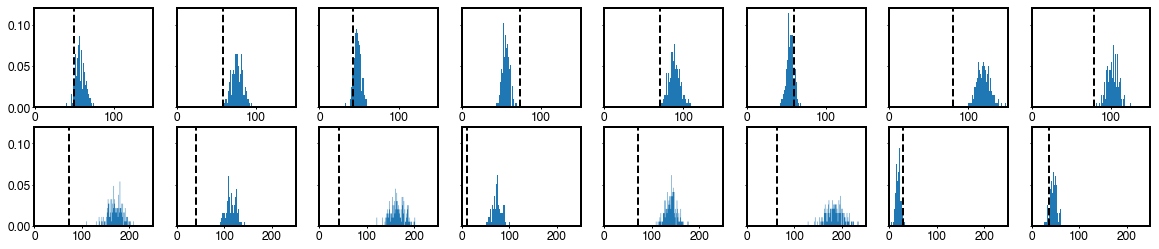

In [8]:
# Single bird

bird = 'B1083'
stim_scm_dict = bird_scm_dict[bird]
bc_tavg = bc_tavg_store[bird]

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
betti_num = 3
bettis = [1,2]
stims = list(bc_tavg.keys())[0:8]
my = 0
for ind, betti_num in enumerate(bettis):
    nmaxyt = 0
    nmaxxt = 0
    for stimind, stim in enumerate(stims):
        final_bettis = bc_tavg[stim][:, -1, 0]
        ax = axs[ind, stimind]
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = final_bettis[betti_num]
        ax.plot([b, b], [0, 100], 'k--', linewidth=2)
        (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxxt = np.amax([nmaxx, nmaxxt])
        if ind > 0:
            xmax = 250
            
            ax.set_xticks(np.arange(0, 300, 100))
        else:
            xmax = 150
    
        ax.set_xlim([-0.1, xmax])
        ax.set_ylim([0, 0.12])
        ax.tick_params(labelsize=12)
        for i in ax.get_xticklabels():
            i.set_fontname('helvetica')
        for i in ax.get_yticklabels():
            i.set_fontname('helvetica')
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
            
        # Calculate empirical p-values
        betti_vals = stim_scm_dict[stim][:, 0, betti_num]
        betti_vals = betti_vals[betti_vals >= 0]
        p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
        if p > 0.5:
            p = 1-p
        print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))
            
        
        #ax.set_title(stim)
plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.eps'.format(bird)))

112.0
141.0
90.0
104.0
164.0
102.0
220.0
188.0
314.0
213.0
302.0
159.0
266.0
352.0
52.0
92.0
158.0
81.0
174.0
160.0
150.0
272.0
162.0
201.0
92.0
184.0
105.0
237.0
68.0
16.0
92.0
88.0
129.0
111.0
69.0
123.0
135.0
116.0
114.0
132.0
18.0
24.0
63.0
6.0
6.0
12.0
34.0
3.0
44.0
63.0
68.0
52.0
74.0
34.0
62.0
33.0
112.0
52.0
42.0
84.0
30.0
129.0
38.0
146.0
84.0
42.0
60.0
94.0
112.0
62.0
74.0
78.0
12.0
8.0
62.0
9.0
6.0
48.0
34.0
4.0


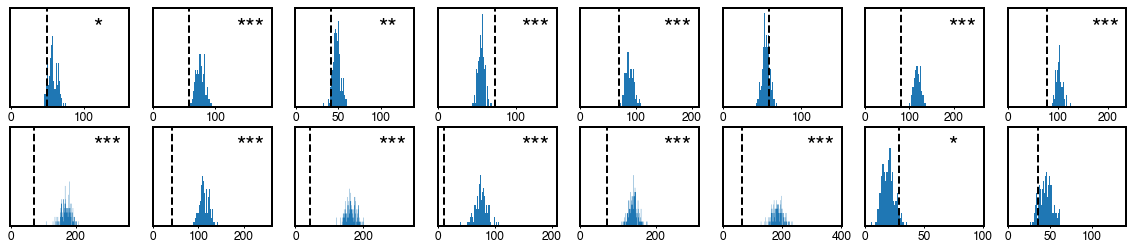

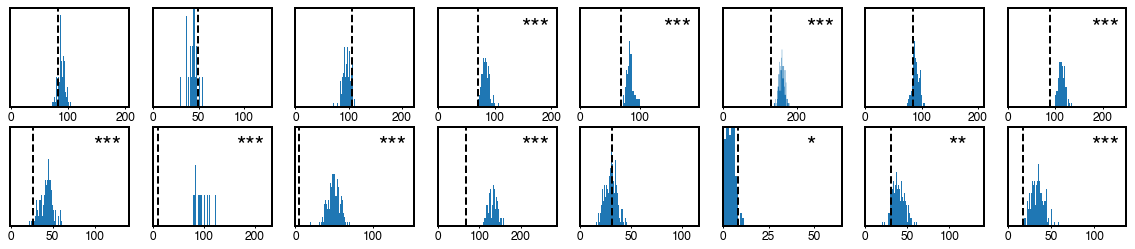

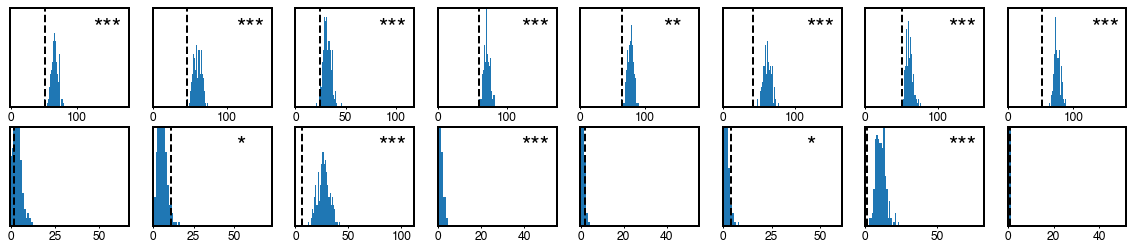

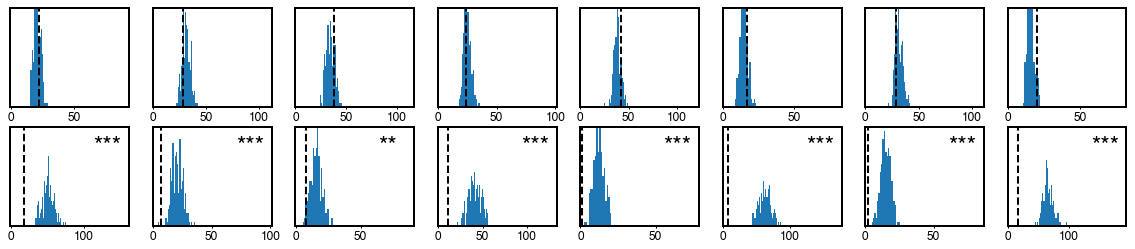

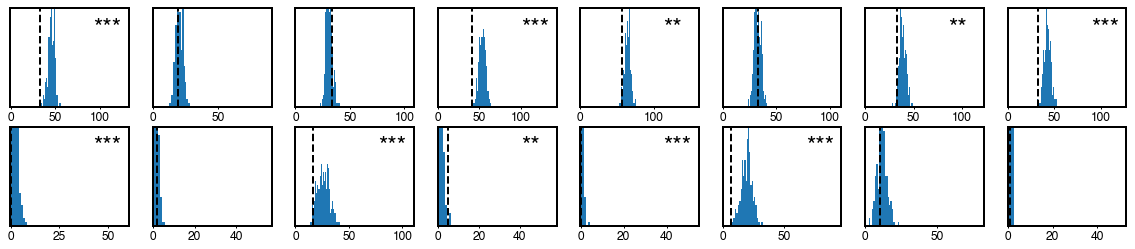

In [9]:
# All bird

for bird in birds:
    stim_scm_dict = bird_scm_dict[bird]
    bc_tavg = bc_tavg_store[bird]

    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
    betti_num = 3
    bettis = [1,2]
    stims = list(bc_tavg.keys())[-8:]
    my = 0
    for ind, betti_num in enumerate(bettis):
        nmaxyt = 0
        nmaxxt = 0
        for stimind, stim in enumerate(stims):
            final_bettis = bc_tavg[stim][:, -1, 0]
            ax = axs[ind, stimind]
            #final_bettis = stim_betticurve_dict[stim][-1]
            b = final_bettis[betti_num]
            ax.plot([b, b], [0, 100], 'k--', linewidth=2)
            (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
            nmaxyt = np.amax([nmaxy, nmaxyt])
            nmaxxt = np.amax([nmaxx, nmaxxt])
            
            if ind > 0:
                xmax = nmaxx+50

                #ax.set_xticks(np.arange(0, 300, 100))
            else:
                xmax = nmaxx+50

            ax.set_xlim([-0.1, xmax])
            ax.set_ylim([0, 0.12])
            ax.tick_params(labelsize=12)
            for i in ax.get_xticklabels():
                i.set_fontname('helvetica')
            for i in ax.get_yticklabels():
                i.set_fontname('helvetica')
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)
            ax.get_yaxis().set_visible(False)
            # Calculate empirical p-values
            betti_vals = stim_scm_dict[stim][:, 0, betti_num]
            betti_vals = betti_vals[betti_vals >= 0]
            p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
            stars = ''
            if p > 0.5:
                p = 1-p
            if p < 0.1:
                stars = '*'
            if p < 0.05:
                stars = '**'
            if p < 0.01:
                stars = '***'
            ax.text(0.7, 0.75, stars, transform=ax.transAxes, fontsize=24)
            #print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))


            #ax.set_title(stim)
    plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.pdf'.format(bird)))